# Extreme Makeover: DSI Edition

In [3]:
import sys
!{sys.executable} -m pip install matplotlib

    100% |████████████████████████████████| 13.8MB 2.4MB/s ta 0:00:011
    100% |████████████████████████████████| 112kB 8.2MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 5.0MB/s ta 0:00:011


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
workshop_data = pd.read_csv("workshops.csv")

In [4]:
workshop_data['Workshop'] = "None"

In [ ]:
#non shitty python way
def workshop_replace(string, new_val):
    workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains(string)), new_val, workshop_data['Workshop'])

In [5]:
#shitty python way
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Python 0')), 'Python 0', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Python 1')), 'Python 1', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Python 2')), 'Python 2', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('R0')), 'R0', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('R-0')), 'R0', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('R1')), 'R1', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('R2')), 'R2', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Hadoop')), 'Hadoop', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Spark')), 'Spark', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Symposium')), 'Symposium', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Visualization')), 'Visualization', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('API')), 'API', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Python0')), 'Python 0', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Python1')), 'Python 1', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Python2')), 'Python 2', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('GBM')), 'GBM', workshop_data['Workshop'])
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Finance')), 'Finance', workshop_data['Workshop'])

In [18]:
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Python 0')), 'Python 0', "None")
workshop_data['Workshop'] = np.where((workshop_data['Workshop_Type'].str.contains('Python 0')), 'Python 0', "None")

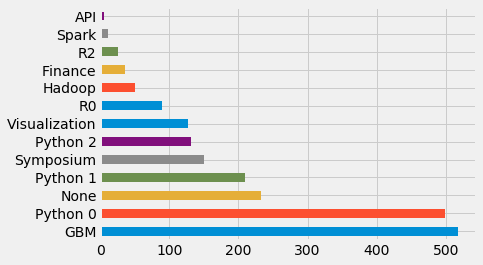

In [6]:
workshop_data['Workshop'].value_counts().plot.barh()

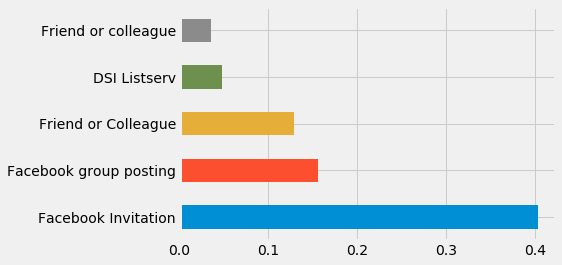

In [42]:
workshop_data['how did you hear about us'].value_counts(normalize=True).head(5).plot.barh()

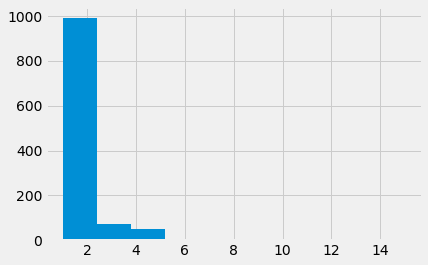

In [45]:
workshop_data['email'].value_counts().hist()

In [8]:
workshop_data['study'].value_counts()

['comput', 'sci']                                     129
['comput', 'and', 'inform', 'sci', 'and', 'engin']     77
['stat']                                               34
['inform', 'system']                                   28
['indust', 'engin']                                    25
['nan']                                                22
['comput', 'engin']                                    19
['elect', 'and', 'comput', 'engin']                    18
['isom']                                               16
['mat', 'sci', 'and', 'engin']                         14
['biom', 'engin']                                      14
['cs']                                                 12
['indust', 'and', 'system', 'engin']                   11
['inform', 'system', 'and', 'op', 'man']                9
['econom']                                              8
['nuclear', 'engin']                                    8
['mathem']                                              7
['elect', 'eng